## Eksplorativna i statistička analiza novosadskih kompanija prema zvaničnim podacima iz finansijskih izveštaja za 2024. godinu

Obuhvata aktivne kompanije iz Novog Sada koje posluju kao društva sa ograničenom odgovornošću (DOO), prema podacima iz finansijskih izveštaja za 2024. godinu.

Izvor podataka: Agencija za privredne registre Republike Srbije

In [703]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = '{:,.2f}'.format

Podaci o novosadskim kompanijama prema podacima iz finansijskih izveštaja iz 2024. godine

In [704]:
df = pd.read_parquet("data/novi_sad_2024.parquet")

DataFrame šifara i opisa delatnosti privrede

In [705]:
delatnosti_df = pd.read_parquet("data/delatnosti.parquet")

### 1. OSNOVNE INFORMACIJE O DATASETU

In [706]:
df.shape

(3327, 23)

In [707]:
df.isna().sum()

MB                     0
PIB                    0
Datum osnivanja        0
Naziv preduzeća        0
Mesto                  0
Poštanski broj         0
Adresa                 0
Telefon             1856
Pravni oblik           0
Šifra delatnosti       0
Naziv delatnosti       0
APR Status             0
NBS Status             0
Bonitetna ocena        0
Veličina               2
Promet (EUR)           0
Neto dobit (EUR)       0
Broj zaposlenih        0
Ebit (EUR)             0
Ebitda (EUR)           0
Email                 98
Zastupnik              3
PDV Obveznik         833
dtype: int64

In [708]:
df.columns

Index(['MB', 'PIB', 'Datum osnivanja', 'Naziv preduzeća', 'Mesto',
       'Poštanski broj', 'Adresa', 'Telefon', 'Pravni oblik',
       'Šifra delatnosti', 'Naziv delatnosti', 'APR Status', 'NBS Status',
       'Bonitetna ocena', 'Veličina', 'Promet (EUR)', 'Neto dobit (EUR)',
       'Broj zaposlenih', 'Ebit (EUR)', 'Ebitda (EUR)', 'Email', 'Zastupnik',
       'PDV Obveznik'],
      dtype='object')

### 2. ČIŠĆENJE PODATAKA

- 2.A. Uklanjanje kolona koje sadrže kontakt informacije i kolona sa podacima koji se neće koristiti.
- 2.B. Brisanje 2 zapisa gde veličina nije određena
- 2.C. Preimenovanje kolona radi lakšeg pozivanja atributa.
- 2.D. Filtriranje šifara delatnosti:
  - Filtriranje retkih delatnosti i onih čija šifra ne može da se podeli na sektor/industriju (count: 48)
  - Svođenje delatnosti na sektor i industrijski nivo
- 2.E. Konverzija datuma osnivanja u godinu osnivanja
- 2.F. Uklanjanje kompanija čiji je prihod 0

2.A. Uklanjanje kolona koje sadrže kontakt informacije i kolona sa podacima koji se neće koristiti.

In [709]:
columns_to_remove = [
    'MB', 'PIB','Naziv preduzeća','Mesto','Poštanski broj', 'Adresa', 'Telefon', 'Pravni oblik','Naziv delatnosti', 'APR Status', 'NBS Status','Email', 'Zastupnik',
       'PDV Obveznik']

df_cleaned = df.drop(columns=columns_to_remove)

2.B. Brisanje 2 zapisa gde veličina nije određena

In [710]:
df_cleaned = df_cleaned[df_cleaned['Veličina'].notna()]

2.C. Preimenovanje kolona radi lakšeg pozivanja atributa.

In [711]:
columns_rename_map = {
    "Datum osnivanja": "godina_osnivanja",
    'Šifra delatnosti':'sifra_delatnosti',
    'Bonitetna ocena':'bonitet',
    'Veličina': 'velicina',
    'Promet (EUR)': 'prihod',
    'Neto dobit (EUR)': 'neto_dobit',
    'Broj zaposlenih': 'broj_zaposlenih',
    'Ebit (EUR)': 'ebit',
    'Ebitda (EUR)': 'ebitda'
}

df_cleaned = df_cleaned.rename(columns=columns_rename_map)

delatnosti_df = delatnosti_df.rename(columns={'CODE':'sifra','LAT': 'opis'})

df_cleaned.columns

Index(['godina_osnivanja', 'sifra_delatnosti', 'bonitet', 'velicina', 'prihod',
       'neto_dobit', 'broj_zaposlenih', 'ebit', 'ebitda'],
      dtype='object')

2.D. Filtriranje šifara delatnosti

In [712]:
# # 2.D.1. Filtriranje retkih delatnosti i onih čija šifra ne može da se podeli na sektor/industriju (count: 48)
delatnosti_counts = df_cleaned['sifra_delatnosti'].value_counts()
retke_delatnosti = delatnosti_counts[delatnosti_counts < 3].index
df_cleaned = df_cleaned[~df_cleaned['sifra_delatnosti'].isin(retke_delatnosti)]

# # 2.D.2. Svođenje delatnosti na sektor i industrijski nivo
df_cleaned['sektor'] = df_cleaned['sifra_delatnosti'].astype(str).str[:2]
df_cleaned.rename(columns={'sifra_delatnosti': 'industrija'}, inplace=True)

2.E. Konverzija datuma osnivanja u godinu osnivanja

In [713]:
df_cleaned['dekada_osnivanja'] = (df_cleaned['godina_osnivanja'].dt.year // 10) * 10
df_cleaned['godina_osnivanja'] = df_cleaned['godina_osnivanja'].dt.year

2.F. Uklanjanje kompanija čiji je prihod 0

In [714]:
df_cleaned = df_cleaned[df_cleaned['prihod'] > 0]

In [715]:
df_cleaned.sample(n=5, random_state=42)

,godina_osnivanja,industrija,bonitet,velicina,prihod,neto_dobit,broj_zaposlenih,ebit,ebitda,sektor,dekada_osnivanja
1097,2020,4321,C2,Mikro,139623,7853,3,11323,15630,43,2020
1378,1995,6201,C2,Mikro,66521,59,2,290,290,62,1990
2876,1992,8211,D1,Mikro,7528,59,0,85,854,82,1990
1682,2023,6201,C1,Mikro,24150,418,1,846,846,62,2020
224,1991,1812,A3,Malo,1801103,98560,19,78989,114199,18,1990


### 3. KONSTRUKCIJA DODATNIH KARAKTERISTIKA (feature engineering)

- 3.A. Vrednost operativnih rashoda
- 3.B. Vrednost amortizacije
- 3.C. marže [neto marža, ebit marža. ebitda marža]
- 3.D. Marža amortizacije
- 3.E. Marža kamata i poreza

In [716]:
df_features = df_cleaned.copy()
del df_cleaned

#### 3.A. Operativni rashodi

Operativni rashodi predstavljaju ukupne troškove poslovanja kompanije koji nastaju tokom osnovne poslovne aktivnosti, bez uzimanja u obzir amortizacije, kamate i poreza. Izračunavaju se kao razlika između prihoda i EBITDA, što omogućava bolji uvid u troškove koji se direktno odnose na proizvodne i operativne procese. Upoređujući operativne rashode između različitih kompanija, možemo dobiti uvid u efikasnost njihovih operacija i način na koji upravljaju svojim troškovima.

In [717]:
df_features['operativni_rashodi'] = round(df_features.prihod - df_features.ebitda, 2)

#### 3.B. Vrednost amortizacije

Amortizacija predstavlja raspodelu troška kapitalnih ulaganja kroz vreme i obuhvata smanjenje vrednosti dugoročne imovine. Izračunava se kao razlika između EBITDA i EBIT. Analizirajući vrednost amortizacije, možemo proceniti kapitalnu intenzivnost poslovanja kompanije i razumeti kako njena ulaganja u imovinu utiču na finansijske performanse. Upoređujući amortizaciju među kompanijama, možemo uočiti razlike u pristupima kapitalnim ulaganjima i njihovim efektima na profitabilnost.

In [718]:
df_features['amortizacija'] = round(df_features.ebitda - df_features.ebit, 2)

#### 3.C. Marže

##### 3.C.1. Neto marža

Neto marža pokazuje koliko profita ostaje od svaka 100 jedinica prihoda nakon što se oduzmu svi troškovi, porezi i kamate. Upoređujući neto marže između kompanija, možemo utvrditi koja je kompanija efikasnija u konverziji prihoda u čist profit.

In [719]:
df_features['net_marza'] = round(df_features.neto_dobit / df_features.prihod, 2)

##### 3.C.2. EBIT marža

EBIT marža pokazuje koliko od svaka 100 jedinica prihoda ostaje nakon operativnih troškova, pre kamata i poreza. Viša EBIT marža pokazuje da je kompanija efikasnija u generisanju profita iz osnovne delatnosti.

In [720]:
df_features['ebit_marza'] = round(df_features.ebit / df_features.prihod, 2)

##### 3.C.3. EBITDA marža

Upoređivanje EBITDA marže pomaže u proceni koja kompanija ima bolju osnovnu operativnu efikasnost, pre nego što se oduzmu negotovinski troškovi kao što je amortizacija. Ovo je posebno korisno za upoređivanje kompanija sa različitim strukturama kapitala ili onih koje posluju u industrijama koje zahtevaju velika ulaganja u opremu, infrastrukturu i dugoročne resurse, kao što su industrija proizvodnje, energetika, telekomunikacije i građevina.

In [721]:
df_features['ebitda_marza'] = round(df_features.ebitda / df_features.prihod, 2)

##### 3.C.4. Marža amortizacije

Razlika između EBITDA i EBIT, izražena kao procenat prihoda, pokazuje koliki deo ostvarenog prihoda se troši na amortizaciju osnovnih sredstava. Ova marža daje uvid u stepen zavisnosti poslovanja od dugotrajne imovine, poput opreme, mašina i objekata. Viša marža ukazuje na kapitalno intenzivnije poslovanje i veća ulaganja u imovinu koja se vremenom troši.

In [722]:
df_features['marza_amortizacije'] = round((df_features.ebitda - df_features.ebit) / df_features.prihod * 100, 2)

##### 3.C.5. Marža kamata i poreza

Razlika između EBIT-a i neto profita pokazuje koliki iznos prihoda se troši na kamate i poreze. Ova vrednost omogućava uvid u finansijsko i poresko opterećenje poslovanja. Veći iznosi ukazuju na veće dugove ili viši poreski teret, što može značajno uticati na konačnu profitabilnost kompanije.

In [723]:
df_features['marza_kamate_poreza'] = round((df_features.ebit - df_features.neto_dobit) / df_features.prihod * 100, 2)

In [724]:
df_features.columns

Index(['godina_osnivanja', 'industrija', 'bonitet', 'velicina', 'prihod',
       'neto_dobit', 'broj_zaposlenih', 'ebit', 'ebitda', 'sektor',
       'dekada_osnivanja', 'operativni_rashodi', 'amortizacija', 'net_marza',
       'ebit_marza', 'ebitda_marza', 'marza_amortizacije',
       'marza_kamate_poreza'],
      dtype='object')

### 4. EKSPLORATIVNA, STATISTIČKA ANALIZA I VIZUELIZACIJA REZULTATA

Napomena o interpretaciji rezultata: 
Sve analize u ovom projektu imaju za cilj da istraže povezanost između pojedinačnih poslovnih pokazatelja kompanija iz Novog Sada. Iako određeni rezultati pokazuju statistički značajne povezanosti, važno je naglasiti da ove analize ne određuju uzročno-posledične odnose, niti identifikuju presudne faktore. Prikazani rezultati pružaju uvid u obrasce koji zaslužuju dodatnu, dublju analizu, uključujući i druge finansijske, operativne i tržišne aspekte poslovanja.

Pored ograničenja u interpretaciji uzročno-posledičnih odnosa, važno je napomenuti da pojedine informacije nisu direktno dostupne u skupu podataka, već su izvedene na osnovu dostupnih finansijskih pokazatelja, zato njihovu tačnost treba tumačiti uslovno, imajući u vidu ograničenja izvora podataka.

Svi iznosi su u hiljadama RSD.

#### Sadržaj:

- A. Prihodi
    - 4.A.1. Prihodi prema veličini kompanije. -- OK
    - 4.A.2. Prihodi prema broju zaposlenih. -- OK
    - 4.A.3. Prihodi prema vrsti sektora poslovanja. -- OK
    - 4.A.4. Prosečni prihodi po zaposlenom prema sektoru poslovanja.
    - 4.A.5. Analiza izolovanih slučajeva (outlier): Sektor sa najvećim brojem outlier-a i njihovo prosečno odstupanje od proseka sektora.

- B. Rashodi
    - 4.B.1. Sektori i industrije sa najvišim i najnižim operativnim rashodima.  ---prihod - EBITDA = operativni rashodixxxxxxxxxxxxxxxxx

- C. Neto dobit
    - 4.C.1. Najprofitabilnije i najmanje profitabilni sektori i industrije.
    - 4.C.2. Neto dobit i broj zaposlenih. -- da li je optimalna utilitizacija zaposlenih u konververziji prihoda u neto dobit
    - 4.C.3. Analiza izolovanih slučajeva (outlier): kompanije sa ekstremno visokim prihodom, ali niskom neto maržom.
    - 4.C.D. Povezanost boniteta i dobitineto kompanija.

- D. Amortizacija kao pokazatelj kapitalnih investiranja -- EBITDA = EBIT + Amortizacija + Deprecijacija
    - 4.D.1. Analiza povezanosti vrednosti amortizacije i prihoda, po sektoru, veličini i bonitetu --- - Scatter plot: amortizacija vs prihod (log-skala ako ima outliera) i korelacija+
    - 4.D.2. Prossečan neto povraćaj na kapitalna ulaganja. KPI: neto_dobit / amortizacija
    - 4.D.3. Prosečna kapitalna ulaganja po zaposlenom po sektoru poslovanja. --- da li je proizvodnja više kapitalno intenzivna od usluga

- E. Marže poslovanja
    - 4.E.1. Neto marža. dekada osnivanja, sektor i industrija poslovanja
    - 4.E.2. EBIT marža. veličina, bonitet, sektor i industrija poslovanja
    - 4.E.3. EBITDA marža: veličina, bonitet, sektor i industrija poslovanja
    - 4.E.4. Marža amortizacije: veličina, bonitet, sektor poslovanja
    - 4.E.5. Marža kamate i poreza. veličina i sektor poslovanja.
    - Marža kamate i poreza prema industriji poslovanja -- Koliko je kapitalno ulaganje vezano za industriji kompanije+

- F. Zaposleni
    - 4.F.1. Prosečan broj zaposlenih prema industriji i sektoru poslovanja.
    - 4.F.2. Test normalne distribucije zaposlenih po prihodima ------ Predlog: Kod “test normalnosti”, koristi histogram + Shapiro-Wilk test (ili Anderson-Darling), po grupama prihoda.
    - 4.F.3. Prosečan broj zaposlenih prema bonitetnom skoru.
    - 4.F.4. Prosečan broj zaposlenih prema dekadi osnivanja.

- G. Razno
    - 4.G.1. Brojčana prezentacija kompanija po veličini
    - 4.G.2. Brojčana prezentacija kompanija po bonitetnoj oceni
    - 4.G.1. Najzastupljeniji sektori i industrije novosadskih kompanija.
    - 4.G.2. Trend analiza po godini/dekadi osnivanja. (npr. firme osnovane 90-ih vs. 2010-ih).

- H. Klaster analiza.


In [725]:
df_analysis = df_features.copy()

#### 4.A. Prihodi

4.A.1. PRIHODI PREMA VELIČINI KOMPANIJE

Prihod se analizira u odnosu na veličinu kompanije kako bi se utvrdilo da li postoje značajne razlike u distribuciji prihoda između različitih kategorija veličine. Za procenu povezanosti koristi se jednofaktorska analiza varijanse (ANOVA), dok se raspodela vizualizuje putem box plotova.

Nulta hipoteza (H₀): Nema značajne razlike u prihodima između različitih kategorija veličine kompanija.

Alternativna hipoteza (H₁): Postoje značajne razlike u prihodima između različitih kategorija veličine kompanija.

In [726]:
# priprema podataka
df_analysis['velicina_kod'] = df_features['velicina'].map({'Mikro': 0, 'Malo': 1, 'Srednje': 2, 'Veliko': 3})
grupe = [grupa['prihod'].values for _, grupa in df_analysis.groupby('velicina_kod')]

# # ANOVA test
f_stat, p_value = f_oneway(*grupe)
print(f"F-statistika: {f_stat}, p-vrednost: {p_value}")

print()

# Za utvrđivanje pravca povezanosti
print(df_analysis.groupby('velicina_kod')['prihod'].mean())

F-statistika: 1513.1161785344525, p-vrednost: 0.0

velicina_kod
0      196,919.02
1    2,601,137.16
2   19,490,112.70
3   80,918,168.44
Name: prihod, dtype: float64


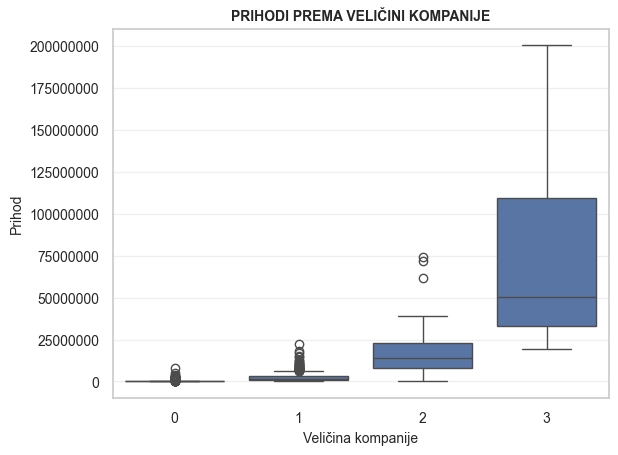

In [727]:
sns.boxplot(x='velicina_kod', y='prihod', data=df_analysis)

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Prihod', fontsize=10)
plt.title('PRIHODI PREMA VELIČINI KOMPANIJE', fontsize=10, fontweight='bold')

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.show()

Zaključak

Na osnovu ANOVA testa, rezultati pokazuju da postoji značajna razlika u prihodima između različitih veličina kompanija (F-statistika: 1426.43, p-vrednost: 0.0). S obzirom na vrlo malu p-vrednost (manju od 0.05), odbacujemo nultu hipotezu (H₀) i prihvatamo alternativnu hipotezu (H₁), što znači da postoji statistički značajna razlika u prihodima između kompanija različitih veličina.

Dodatno, analiza prosečnih prihoda prema veličini kompanije ukazuje da se sa povećanjem veličine kompanije povećavaju i prihodi. Ovo potvrđuje da veće kompanije ostvaruju značajno veće prihode u poređenju sa manjim kompanijama.

4.A.2. PRIHODI PREMA BROJU ZAPOSLENIH

Prihod se analizira u odnosu na broj zaposlenih kako bi se utvrdilo postoji li povezanost između broja zaposlenih i visine prihoda kompanije. Za ovu analizu koristi se linearna regresija, koja testira da li postoji linearan odnos između ove dve varijable. Uz regresiju, biće korišćen i scatter plot za vizualizaciju odnosa između broja zaposlenih i prihoda. Ukoliko se pokaže značajna povezanost, biće moguće doneti zaključke o tome kako promene u broju zaposlenih utiču na prihode.

Nulta hipoteza (H₀): Nema linearne povezanosti između broja zaposlenih i prihoda.

Alternativna hipoteza (H₁): Postoji linearna povezanost između broja zaposlenih i prihoda.

In [728]:
lr_model = LinearRegression()

# Treniranje modela
lr_model.fit(df_analysis[['broj_zaposlenih']], df_analysis['prihod'])

# Predikcija
predicted = lr_model.predict(df_analysis[['broj_zaposlenih']])

# Prikazivanje koeficijenata
print(f'Koeficijent: {lr_model.coef_[0]}')
print(f'Intercept: {lr_model.intercept_}')

Koeficijent: 85955.54081157812
Intercept: 310764.8293602853


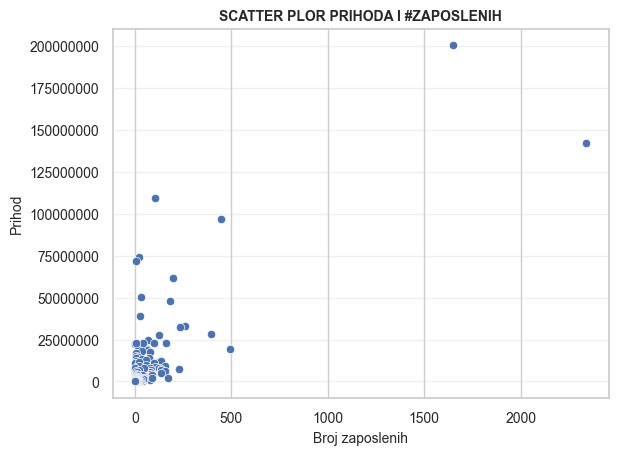

In [729]:
sns.scatterplot(x='broj_zaposlenih', y='prihod', data=df_analysis)

plt.xlabel('Broj zaposlenih', fontsize=10)
plt.ylabel('Prihod', fontsize=10)
plt.title('SCATTER PLOR PRIHODA I #ZAPOSLENIH', fontsize=10, fontweight='bold')

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.show()

Zaključak

Na osnovu rezultata linearne regresije, koeficijent od 122,246.73 ukazuje na to da za svaki dodatni zaposleni, prihod raste za približno 122,246.73 jedinica. Intercept od 79,039.23 označava očekivani prihod u slučaju kada broj zaposlenih iznosi nula. Sa pozitivnim koeficijentom, ovo sugeriše postojanje pozitivne linearne povezanosti između broja zaposlenih i prihoda kompanije.

S obzirom na ove rezultate, može se zaključiti da veći broj zaposlenih ima pozitivan uticaj na prihod kompanije, odnosno, kako broj zaposlenih raste, prihod takođe raste.

Nulta hipoteza (H₀): Ne postoji linearna povezanost između broja zaposlenih i prihoda.

Alternativna hipoteza (H₁): Postoji linearna povezanost između broja zaposlenih i prihoda.

Na osnovu analize, možemo odbaciti nultu hipotezu i prihvatiti alternativnu hipotezu, što znači da postoji statistički značajna linearna povezanost između broja zaposlenih i prihoda.

4.A.3. PRIHODI PREMA VRSTI SEKTORA POSLOVANJA

U ovoj analizi posmatra se raspodela prihoda po različitim vrstama sektora poslovanja kako bi se identifikovali delatnosti sa najvećim i najmanjim prihodima.

In [730]:
print('SEKTORI SA NAJVEÇIM PRIHODIMA:')
print()

top5_sektora = (
    df_analysis.groupby('sektor')['prihod']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

company_count = df_analysis.groupby('sektor')['prihod'].count().reset_index(name='company_count')

top5_sektora = top5_sektora.merge(delatnosti_df, left_on='sektor', right_on='sifra', how='left')
top5_sektora = top5_sektora.merge(company_count, on='sektor', how='left')

top5_sorted = top5_sektora.sort_values(by='prihod', ascending=False)

for i, row in top5_sorted.iterrows():
    print(f"- Sektor {row['sektor']} ({row['opis']}):\n"
          f"  Prosečan prihod: {round(row['prihod'], 2)}\n"
          f"  Broj kompanija: {row['company_count']}\n")

SEKTORI SA NAJVEÇIM PRIHODIMA:

- Sektor 91 (Delatnost biblioteka, arhiva, muzeja galerija i zbirki i ostale kulturne delatnosti):
  Prosečan prihod: 42709925.75
  Broj kompanija: 4

- Sektor 10 (Proizvodnja prehrambenih proizvoda):
  Prosečan prihod: 12574116.95
  Broj kompanija: 20

- Sektor 42 (Izgradnja ostalih građevina):
  Prosečan prihod: 2715858.31
  Broj kompanija: 16

- Sektor 59 (Kinematografska i televizijska produkcija, snimanje zvučnih zapisa i izdavanje muzičkih zapisa):
  Prosečan prihod: 2449721.67
  Broj kompanija: 12

- Sektor 72 (Naučno istraživanje i razvoj):
  Prosečan prihod: 2418715.4
  Broj kompanija: 15



In [731]:
print('SEKTORI SA NAJMANJIM PRIHODIMA:')
print()

bottom5_sektora = (
    df_analysis.groupby('sektor')['prihod']
    .mean()
    .sort_values(ascending=False)
    .tail(5)
    .reset_index()
)

company_count = df_analysis.groupby('sektor')['prihod'].count().reset_index(name='company_count')

bottom5_sektora = bottom5_sektora.merge(delatnosti_df, left_on='sektor', right_on='sifra', how='left')
bottom5_sektora = bottom5_sektora.merge(company_count, on='sektor', how='left')

top5_sorted = bottom5_sektora.sort_values(by='prihod', ascending=True)

for i, row in top5_sorted.iterrows():
    print(f"- Sektor {row['sektor']} ({row['opis']}):\n"
          f"  Prosečan prihod: {round(row['prihod'], 2)}\n"
          f"  Broj kompanija: {row['company_count']}\n")

SEKTORI SA NAJMANJIM PRIHODIMA:

- Sektor 14 (Proizvodnja odevnih predmeta):
  Prosečan prihod: 60831.75
  Broj kompanija: 8

- Sektor 85 (Obrazovanje):
  Prosečan prihod: 71423.67
  Broj kompanija: 48

- Sektor 96 (Ostale lične uslužne delatnosti):
  Prosečan prihod: 79869.3
  Broj kompanija: 23

- Sektor 69 (Pravni i računovodstveni poslovi):
  Prosečan prihod: 121143.31
  Broj kompanija: 77

- Sektor 66 (Pomoćne delatnosti u pružanju finansijskih usluga i osiguranju):
  Prosečan prihod: 123794.0
  Broj kompanija: 20



4.A.4. PROSEČNI PRIHODI PO ZAPOSLENOM PREMA SEKTORU POSLOVANJA



----------------- NE VALJA STARII TEKST -----------------
Poređenje broja zaposlenih prema delatnosti poslovanja omogućava analizu veze između broja radnika i specifičnosti industrije.
Hipoteza: Sektori sa većim obimom poslovanja ili specifičnim potrebama često zahtevaju veći broj zaposlenih, dok manji ili efikasniji sektori mogu operisati sa manjim brojem radnika.
Ovaj pregled pomaže u identifikaciji obrazaca zapošljavanja unutar različitih industrija i može biti koristan za procenu resursnih potreba po sektorima.

4.A.5. Analiza izolovanih slučajeva (outlier amaliza)

#### 4.B. Rashodi

4.B.1. Sektori i industrije sa najvišim i najnižim operativnim rashodima.

#### 4.C. Neto dobit


4.C.1. Najprofitabilnije i najmanje profitabilni sektori i industrije.


4.C.2. Neto dobit i broj zaposlenih. -- da li je optimalna utilitizacija zaposlenih u konververziji prihoda u neto dobit


4.C.D. Povezanost boniteta i neto dobiti kompanija.

4.C.5. Analiza izolovanih slučajeva (outlier): kompanije sa ekstremno visokim prihodom, ali niskom neto maržom.

#### 4.D. Amortizacija kao pokazatelj kapitalnih investiranja

4.D.1. Analiza povezanosti vrednosti amortizacije i prihoda, po sektoru, veličini i bonitetu

4.D.2. Prossečan neto povraćaj na kapitalna ulaganja.

4.D.3. Prosečna kapitalna ulaganja po zaposlenom po sektoru poslovanja.

4.E.4. Marža amortizacije: veličina, bonitet, sektor poslovanja.

4.E.5. Marža kamate i poreza. veličina i sektor poslovanja.

#### 4.F. Zaposleni

4.F.1. Prosečan broj zaposlenih prema industriji i sektoru poslovanja.

4.F.2. Test normalne distribucije zaposlenih po prihodima

4.F.3. Prosečan broj zaposlenih prema bonitetnom skoru.

4.E.4. Marža amortizacije: veličina, bonitet, sektor poslovanja

#### F. Zaposleni

4.F.1. Prosečan broj zaposlenih prema industriji i sektoru poslovanja.

4.F.2. Test normalne distribucije zaposlenih po prihodima.

4.F.3. Prosečan broj zaposlenih prema bonitetnom skoru.

4.F.4. Prosečan broj zaposlenih prema dekadi osnivanja.

#### G. Ostalo

4.G.1. NUMERIČKI PRIKAZ KOMPANIJA PREMA VELIČINI

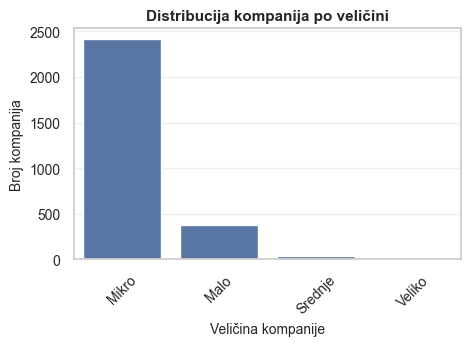

In [732]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_analysis, x='velicina', order=df_analysis['velicina'].value_counts().index)

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Broj kompanija', fontsize=10)
plt.title('Distribucija kompanija po veličini', fontsize=11, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)
# plt.tight_layout()
plt.show()

4.G.2. NUMERIČKI PRIKAZ KOMPANIJA PO BONITETNOJ OCENI

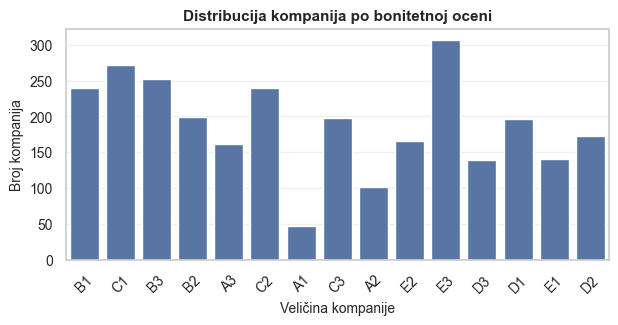

In [733]:
plt.figure(figsize=(7, 3))
sns.countplot(data=df_analysis, x='bonitet')

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Broj kompanija', fontsize=10)
plt.title('Distribucija kompanija po bonitetnoj oceni', fontsize=11, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

4.G.3. Najzastupljeniji sektori i industrije novosadskih kompanija.

In [734]:
most_common_sectors = (
    df_analysis['sektor'].value_counts()
    .head(10)
    .reset_index(name='broj_kompanija')
    .rename(columns={'index': 'sektor'})
    .merge(delatnosti_df[['sifra', 'opis']], left_on='sektor', right_on='sifra', how='left')
)

most_common_sectors['opis'] = most_common_sectors['opis'].str.split('[,;]').str[0]
most_common_sectors.drop(columns=['sifra', 'sektor'], inplace=True)

df_analysis['industrija'] = df_analysis['industrija'].astype(str)
most_common_industries = (
    df_analysis['industrija'].value_counts()
    .head(10)
    .reset_index(name='broj_kompanija')
    .rename(columns={'index': 'industrija'})
    .merge(delatnosti_df[['sifra', 'opis']], left_on='industrija', right_on='sifra', how='left')
)

most_common_industries['opis'] = most_common_industries['opis'].str.extract(r'^(.{0,40}(?:\s|$))')[0].str.strip()
most_common_industries.drop(columns=['sifra'], inplace=True)

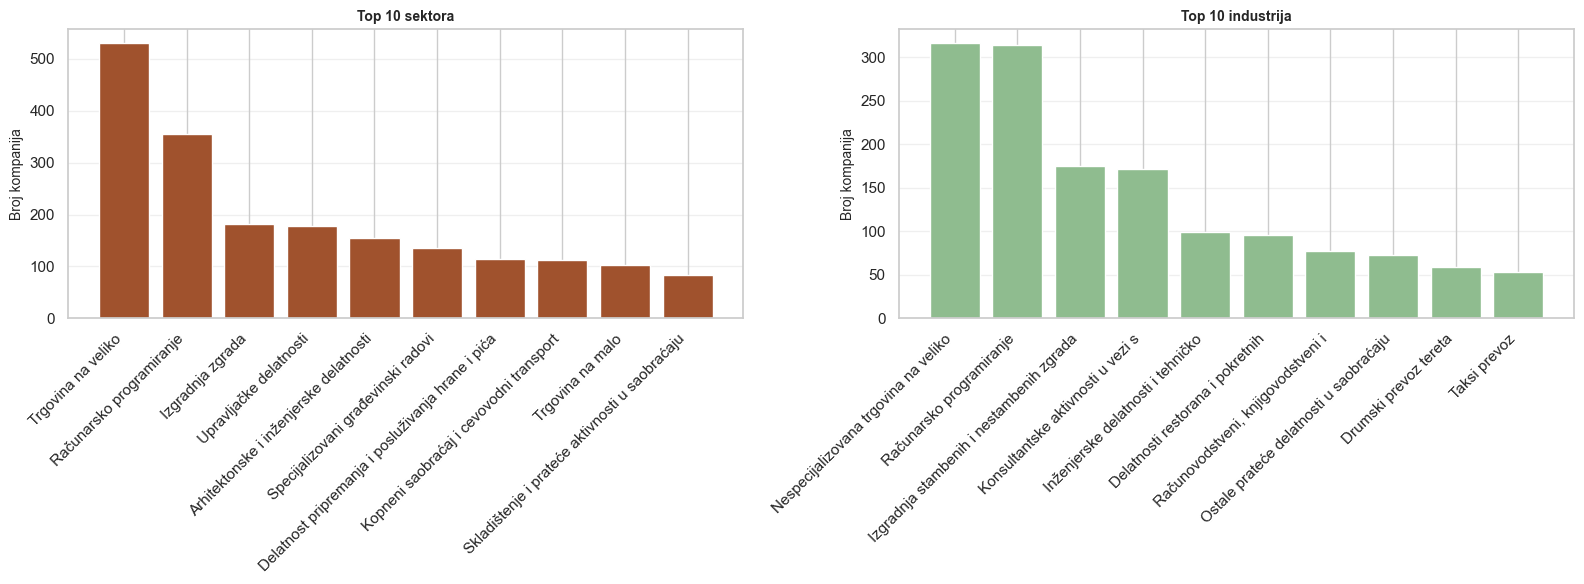

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Sektori
ax1.bar(most_common_sectors['opis'], most_common_sectors['broj_kompanija'], color='Sienna')
ax1.set_title('Top 10 sektora', fontsize=10, fontweight='bold')
ax1.set_ylabel('Broj kompanija', fontsize=10)
ax1.set_xticks(range(len(most_common_sectors)))
ax1.set_xticklabels(most_common_sectors['opis'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Industrije
ax2.bar(most_common_industries['opis'], most_common_industries['broj_kompanija'], color='DarkSeaGreen')
ax2.set_title('Top 10 industrija', fontsize=10, fontweight='bold')
ax2.set_ylabel('Broj kompanija', fontsize=10)
ax2.set_xticks(range(len(most_common_industries)))
ax2.set_xticklabels(most_common_industries['opis'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

4.G.4. Trend analiza po dekadi osnivanja

In [ ]:
trend_df = df_analysis.groupby('dekada_osnivanja').agg({
    'prihod': 'mean',
    'neto_dobit': 'mean',
    'broj_zaposlenih': 'mean',
    'ebit': 'mean',
    'ebitda': 'mean',
    'operativni_rashodi': 'mean',
    'amortizacija': 'mean',
    'net_marza': 'mean',
    'ebit_marza': 'mean',
    'ebitda_marza': 'mean',
    'marza_amortizacije': 'mean',
    'marza_kamate_poreza': 'mean'
}).reset_index()

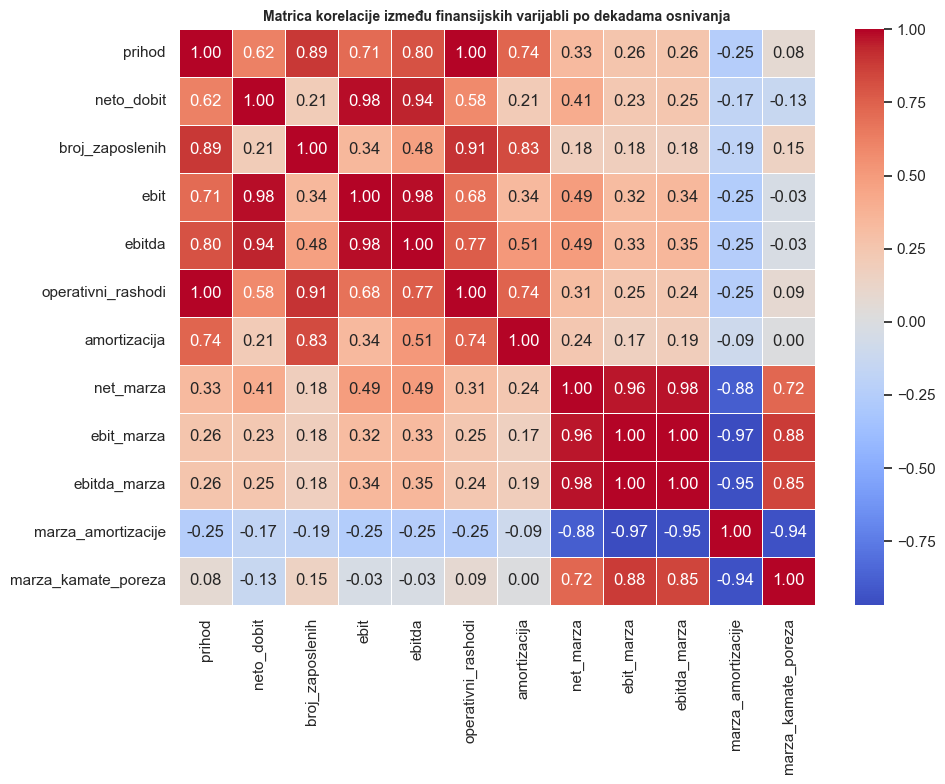

In [771]:
correlation_matrix = trend_df.drop(columns=['dekada_osnivanja']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Matrica korelacije između finansijskih varijabli po dekadama osnivanja', fontsize=10, fontweight='bold')
plt.tight_layout()

plt.show()

Vizuelizacija prihoda i broja zaposlenih po dekadama

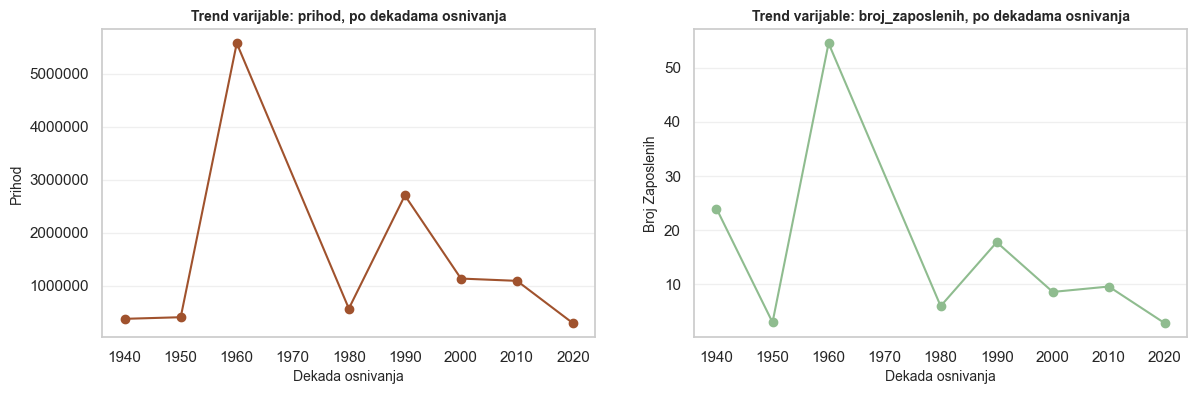

In [ ]:
var_1 = 'prihod'
var_2 = 'broj_zaposlenih'

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(trend_df['dekada_osnivanja'], trend_df[var_1], marker='o', color='Sienna')
axes[0].set_title(f'Trend varijable: {var_1}, po dekadama osnivanja', fontsize=10, fontweight='bold')

axes[0].yaxis.set_major_formatter(ScalarFormatter())
axes[0].yaxis.get_major_formatter().set_scientific(False)

axes[0].set_xlabel('Dekada osnivanja', fontsize=10)
axes[0].set_ylabel('Prihod', fontsize=10)

axes[0].grid(False) 
axes[0].grid(True, axis='y', alpha=0.3) 

# Broja zaposlenih po dekadama osnivanja
axes[1].plot(trend_df['dekada_osnivanja'], trend_df[var_2], marker='o', color='DarkSeaGreen')
axes[1].set_title(F'Trend varijable: {var_2}, po dekadama osnivanja', fontsize=10, fontweight='bold')

axes[1].set_xlabel('Dekada osnivanja', fontsize=10)
axes[1].set_ylabel('Broj Zaposlenih', fontsize=10)

axes[1].grid(False)  
axes[1].grid(True, axis='y', alpha=0.3) 

plt.show()


Iz podataka se može primetiti da je postojala gotovo paralelna promena u trendovima prihoda i broja zaposlenih kroz dekade, osim u 1940. godini. Tokom svih godina, povećanje ili smanjenje prihoda uglavnom je pratilo slične promene u broju zaposlenih. Najveći prihodi i broj zaposlenih zabeleženi su u 1960. godini, dok su u 2020. godini oba pokazatelja drastično opala. Prema tome, postoji snažna veza između broja zaposlenih i prihoda u firmama kroz vremenski period, osim u 1940. godini, kada je prihod bio znatno viši, ali je broj zaposlenih bio izuzetno nizak.

#### H. Klaster analiza.

Priprema i enkodiranje podataka